<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Faire une étude de marché sur le poulet - Partie Analyse de données</h1>
</div>

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [7]:
# Importer les packages nécessaires
import pandas as pd # Manipuler les dataframes
import numpy as np # Calcul matricienne

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import plotly.express as px

# Préparation des données et clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Grouper les colonnes
from sklearn import datasets
from sklearn.cluster import KMeans # Grouper les lignes
from sklearn.metrics import silhouette_score

# Ignorer les warning
import warnings
warnings.filterwarnings("ignore") # Des erreurs peuvent apparaitre durant l'entrainement du Kmeans

# Tableau
from tabulate import tabulate

In [8]:
#Importation du fichier CSV poulet_qui_chante_2019.csv
df = pd.read_csv('poulet_qui_chante_2019.csv', delimiter=';')
liste_reg = ['Region', 'Pays']
df_region = df[liste_reg]

In [9]:
# Enlever les colonnes inutiles (utiles pour faire des analyses externes)
df = df.drop(columns = ["Region","Code","Year", "Urbain %", "Rural %","Bœuf (Kg/personne)", "Poissons (Kg/personne)","Autres viandes (Kg/personne)","Rank", "Export poulets (1000 têtes)", "Export poulets (tonnes)"])

# Permet d'ameliorer la visibilité du dataframe
nouveaux_noms = {
    'Population': 'Population',
    'Poulet (Kg/personne)': 'Consommation',
    'Import poulets (1000 têtes)': 'Importations_têtes',
    'Import poulets (tonnes)': 'Importations_tonnes',
    'Production / Tonnes': 'Production',
    'Political_Stability': 'Stabilité_politique',
    'PIB_par_habitant ($)': 'PIB',
    'Disponibilités de matière grasse (g/personne/jour)': 'Disponibilité_mg',
    'Disponibilités protéiques (g/personne/jour)': 'Disponibilité_protéines'
}

# Renommer les colonnes
df.rename(columns=nouveaux_noms, inplace=True)

In [10]:
# On vérifie les informations sur les données.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pays                     168 non-null    object 
 1   Population               168 non-null    int64  
 2   Consommation             168 non-null    float64
 3   Importations_têtes       168 non-null    int64  
 4   Importations_tonnes      168 non-null    float64
 5   Production               168 non-null    int64  
 6   Stabilité_politique      168 non-null    float64
 7   PIB                      168 non-null    float64
 8   Disponibilité_mg         168 non-null    float64
 9   Disponibilité_protéines  168 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 13.3+ KB


In [11]:
# La colonne Pays devient un index
df.set_index('Pays', inplace=True)

X = df.values
X.shape

n = X.shape[0] #nombre d'observation
p = X.shape[1] #nombre de variables
column_names = df.columns.tolist()

In [12]:
# Afficher les premières lignes du dataframe
df.head()

,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines
Pays,,,,,,,,,
Afghanistan,37769499,1.810000,9067,14671.92,28324,-2.66,497.741429,40.4,56.3
Albania,2854191,12.339987,1146,19304.04,13127,0.11,5396.214243,114.4,113.0
Algeria,42705368,6.560000,7183,0.09,273839,-1.04,4021.983266,93.1,90.0
Angola,32353588,9.699999,1181,253768.53,49016,-0.36,2191.347764,56.8,48.9
Antigua and Barbuda,92117,65.225050,3,6010.01,26,0.95,18730.004797,90.6,81.0


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Création d'un dendrogramme pour clustering</h2>
</div>

In [14]:
# Centrer et réduire nos données
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

In [15]:
# Vérification des moyennes et écart-type (elles doivent être de 0, 1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8
mean,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


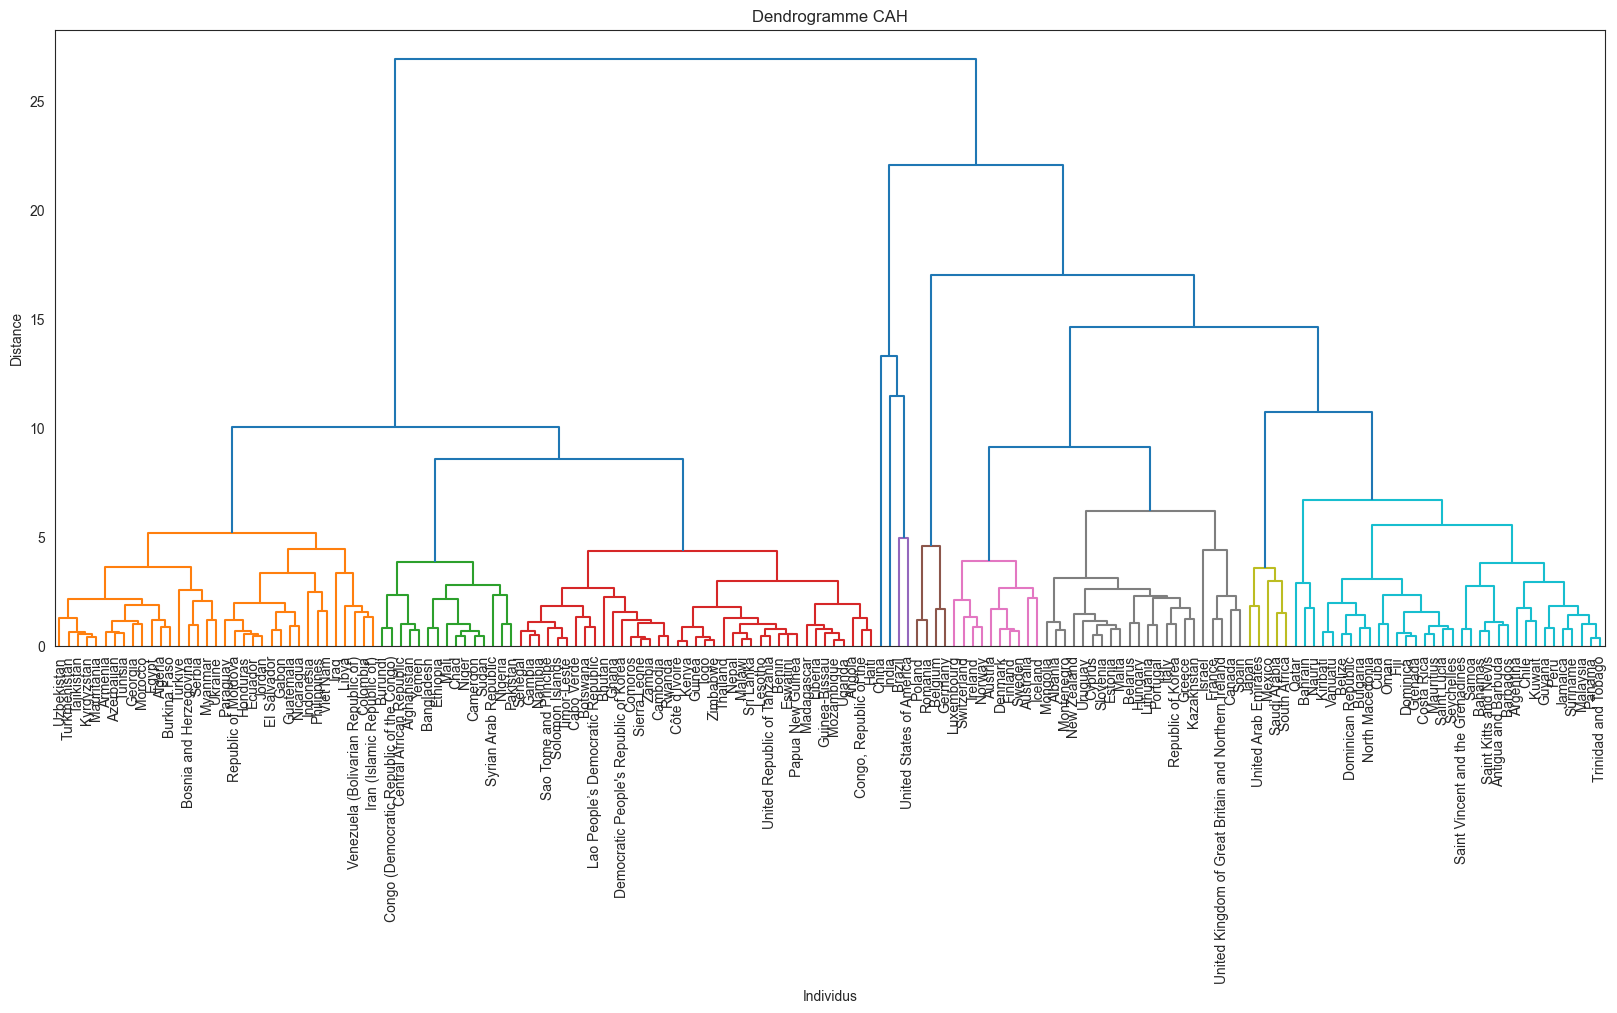

In [16]:
# Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Tracer le dendrogramme
plt.figure(figsize=(20, 8))
sns.set_style('white')
dendrogram(Z, labels = df.index, leaf_font_size=10, color_threshold=7, orientation='top')

# Création des légendes
plt.title('Dendrogramme CAH')
plt.xlabel('Individus')
plt.ylabel('Distance')
plt.savefig('dendrogramme.png')

# Afficher le résultat
plt.show()

In [17]:
# Déterminer les clusters en coupant le dendrogramme
clusters = fcluster(Z, 4, criterion='maxclust')

# Créer une nouvelle DataFrame pour conserver la colonne Cluster_CAH
df_CAH = df.copy()

# Ajouter les étiquettes de cluster au DataFrame
df_CAH['Cluster_CAH'] = clusters

centroids = df_CAH.groupby('Cluster_CAH').median()
centroids

,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines
Cluster_CAH,,,,,,,,,
1,16126866.0,7.229999,607.0,7462.220,67234.0,-0.520,2122.078397,61.10,66.7
2,855721001.5,30.920000,948.5,32769.035,18041757.5,-0.485,9494.592185,118.85,99.4
3,28668561.5,20.419998,129387.5,155062.315,1025486.0,0.560,31170.867491,145.25,106.0
4,4441100.0,32.897423,279.0,18463.560,71651.0,0.680,18730.004797,114.40,90.7


In [18]:
# Nombre de pays par cluster
nb_pays_cluster = df_CAH.groupby('Cluster_CAH').count()
nb_pays_cluster

,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines
Cluster_CAH,,,,,,,,,
1,89,89,89,89,89,89,89,89,89
2,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4
4,71,71,71,71,71,71,71,71,71


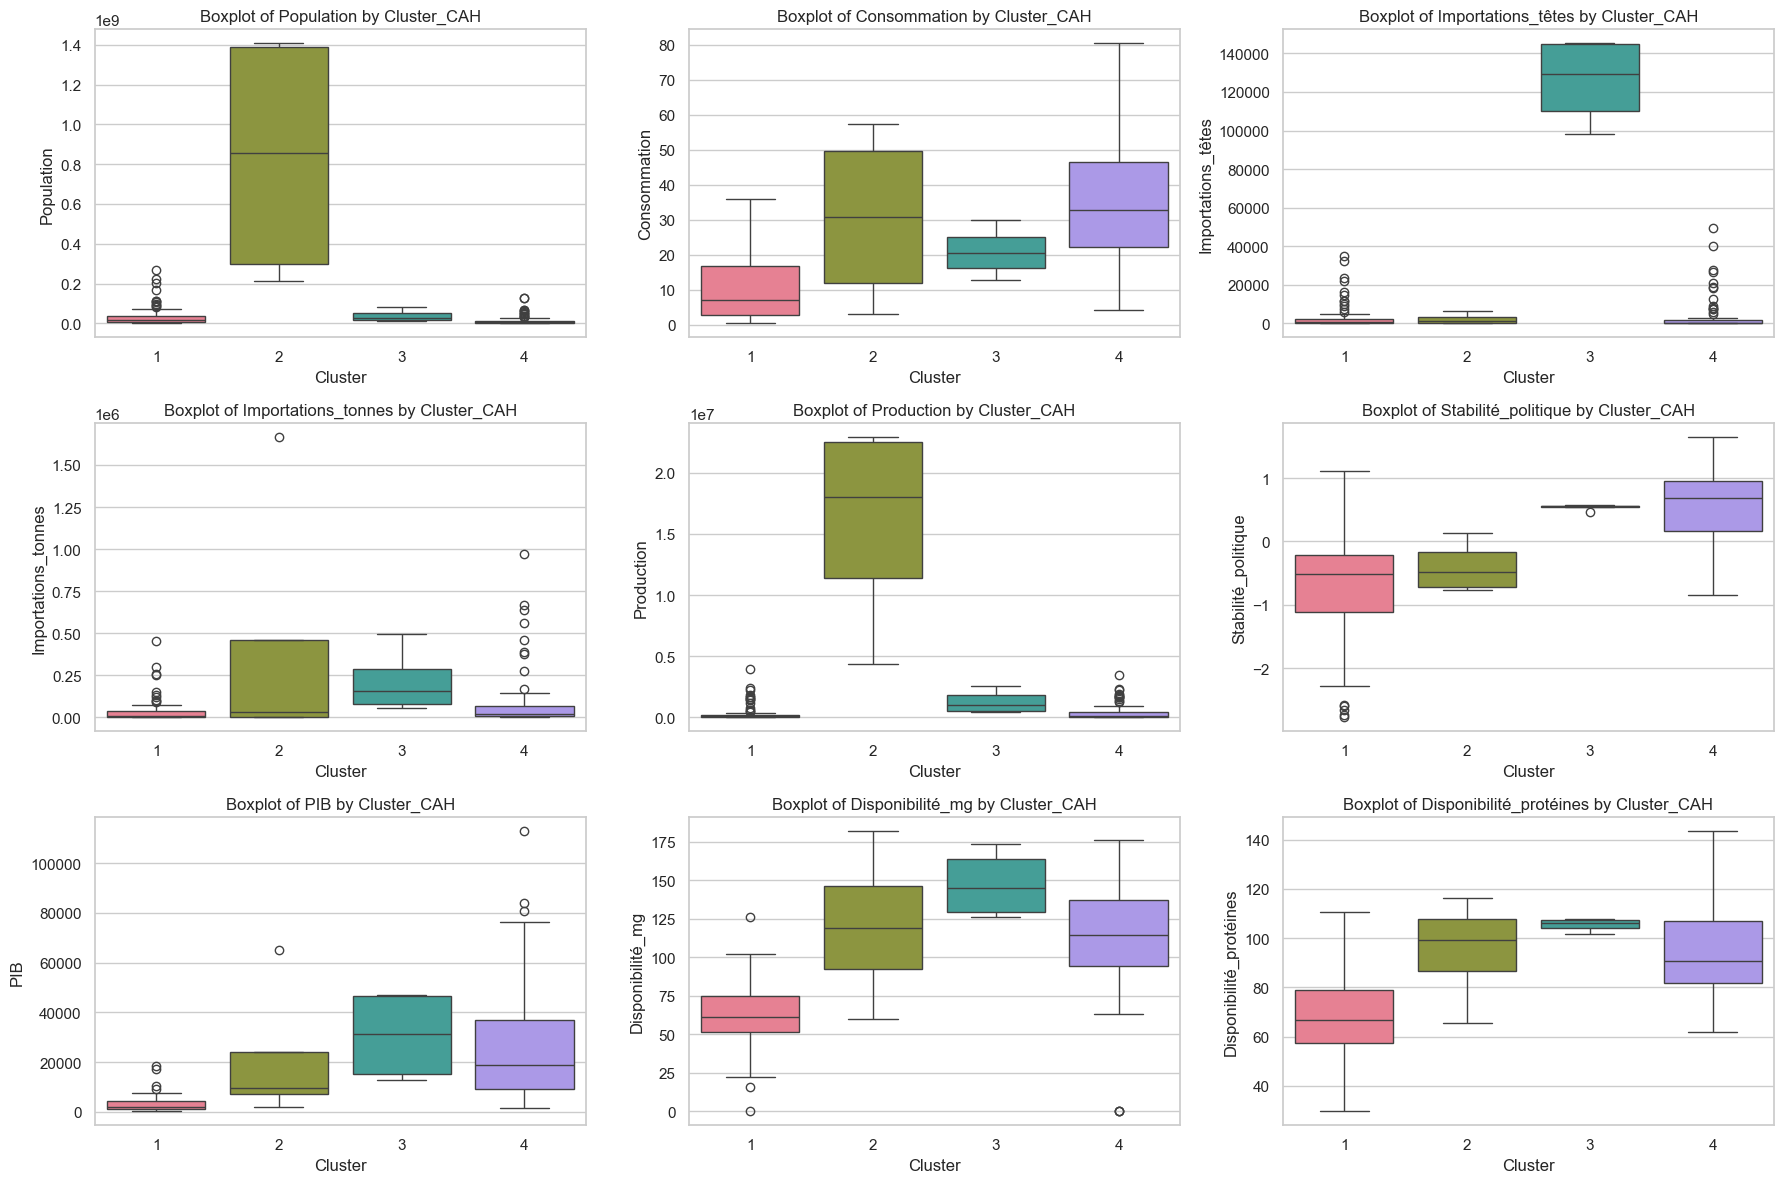

In [19]:
# Configurer le style de seaborn pour des plots plus esthétiques
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# Palette de couleurs pour les clusters
palette = sns.color_palette("husl", len(df_CAH['Cluster_CAH'].unique()))

columns_to_plot = df_CAH.columns[:-1]  # Toutes les colonnes sauf 'Cluster_CAH'
# Boucle à travers chaque colonne sauf 'Cluster_CAH'
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1)  # Créer une grille de 3x3
    sns.boxplot(x='Cluster_CAH', y=column, data=df_CAH, palette=palette)
    plt.title(f'Boxplot of {column} by Cluster_CAH')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    
# Ajuster l'espace entre les plots pour une meilleure lisibilité
plt.tight_layout()

# Afficher les plots
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Réalisation d'une ACP</h2>
</div>

In [21]:
#instanciation
pca = PCA(svd_solver='full')

#Calcul des composantes principales
coord = pca.fit_transform(X_scaled)

#nombre de composantes calculées
print(pca.n_components_)

9


In [22]:
# Nombre de composantes
n_components = 9
x_list = range(1, n_components+1)

In [23]:
# Pourcentage de variance expliquée par chaque composante
explained_variance_ratio = (pca.explained_variance_ratio_*100).round(2)
print("Pourcentage de variance expliquée par chaque composante :")
print(explained_variance_ratio)

# Pourcentage de variance expliquée cumulée
cumulative_explained_variance = explained_variance_ratio.cumsum().round()

print("Pourcentage de variance expliquée cumulée :")
print(cumulative_explained_variance)

Pourcentage de variance expliquée par chaque composante :
[36.02 23.01 11.72  7.42  6.94  5.63  4.23  3.17  1.87]
Pourcentage de variance expliquée cumulée :
[ 36.  59.  71.  78.  85.  91.  95.  98. 100.]


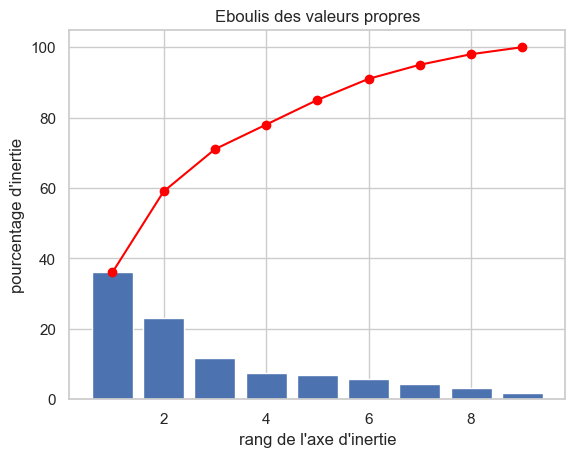

In [24]:
# Tracer le pourcentage de variance expliquée
plt.bar(x_list, explained_variance_ratio)
plt.plot(x_list, cumulative_explained_variance,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

# Afficher le graphique
plt.show(block=False)

In [25]:
# Appliquer l'ACP pour avoir 4 composants du moment que 4 composants nous permettent d'avoir 78% de l'information
pca = PCA(n_components=4).fit(X_scaled)
Xk_Projected = pca.transform(X_scaled)

# Vérification des moyennes et écart-type
idx = ["mean", "std"]
pd.DataFrame(Xk_Projected).describe().round(3).loc[idx, :]

,0,1,2,3
mean,0.000,0.000,-0.00,0.00
std,1.806,1.443,1.03,0.82


In [26]:
# Créer un DataFrame pour stocker les composantes principales
components_df = pd.DataFrame(pca.components_.T, columns=[f'Composante {i+1}' for i in range(4)], index=df.columns)

# Afficher le tableau
print(tabulate(components_df, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│                         │   Composante 1 │   Composante 2 │   Composante 3 │   Composante 4 │
╞═════════════════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ Population              │      0.0597291 │      0.605072  │     -0.0852088 │      -0.170672 │
├─────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Consommation            │      0.324147  │     -0.113284  │     -0.474981  │       0.588398 │
├─────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Importations_têtes      │      0.202216  │      0.0191738 │      0.813754  │       0.384015 │
├─────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Importations_tonnes     │      0.17343   │      0.48775   │      0.0722539 │       0.42886  │
├─────────────────────────┼─────────────

<Axes: >

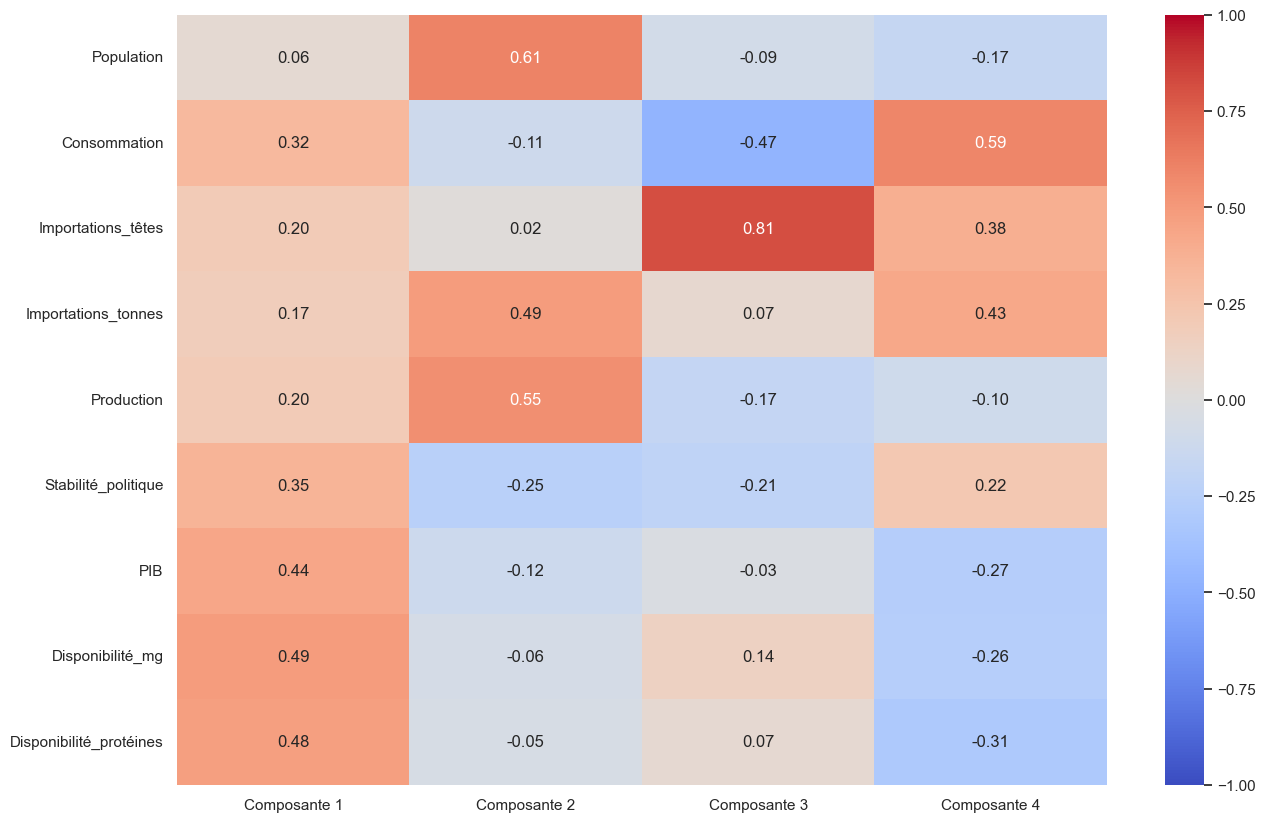

In [27]:
# heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(components_df, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - kmeans pour le clustering avec la méthode du coude</h2>
</div>

In [29]:
# Une liste vide pour enregistrer les inerties
inertia_list = []

# Pour chaque nombre de clusters
for i in range(1, 10):
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=i, init='k-means++')
    
    # On entraîne le k-means sur les composantes principales
    kmeans.fit(Xk_Projected)
    
    # On enregistre l'inertie obtenue
    inertia_list.append(kmeans.inertia_)

Le nombre optimal de clusters selon la méthode de silhouette est : 4


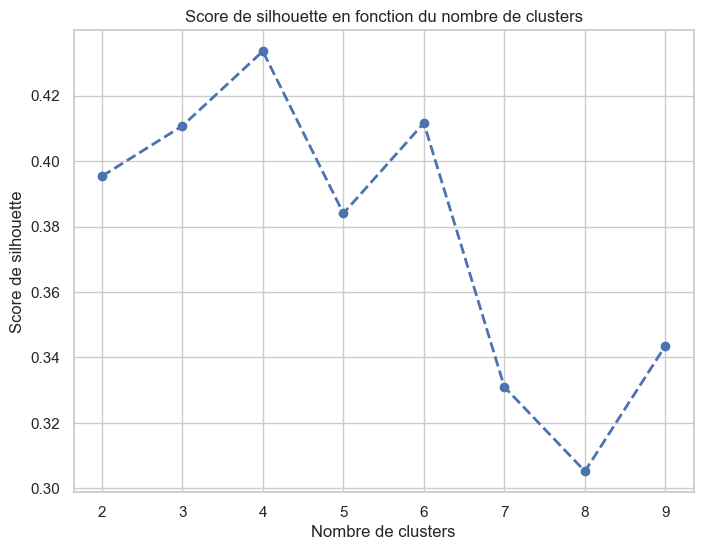

<Figure size 640x480 with 0 Axes>

In [30]:
# Une liste vide pour enregistrer les scores de silhouette
silhouette_scores = []

# Pour chaque nombre de clusters
for i in range(2, 10):  # On commence à partir de 2 clusters pour utiliser silhouette_score
    # On instancie un k-means pour i clusters
    kmeans = KMeans(n_clusters=i, init='k-means++')
    
    # On entraîne le k-means sur les composantes principales
    kmeans.fit(Xk_Projected)
    
    # On calcule le score de silhouette
    silhouette_avg = silhouette_score(Xk_Projected, kmeans.labels_)
    
    # On enregistre le score de silhouette obtenu
    silhouette_scores.append(silhouette_avg)

# Trouver le nombre de clusters qui maximise le score de silhouette
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 pour compenser le démarrage à partir de 2 clusters

print(f"Le nombre optimal de clusters selon la méthode de silhouette est : {optimal_clusters}")

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='--', color='b', linewidth=2)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction du nombre de clusters')
plt.xticks(np.arange(2, 10, step=1))
plt.grid(True)
plt.show()
plt.savefig('silhouete.jpg')

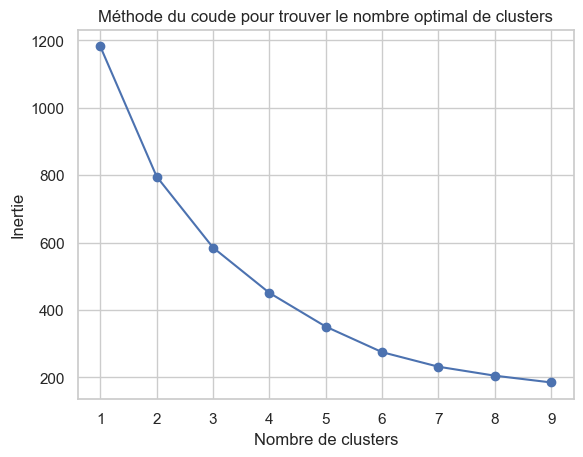

In [31]:
# Tracer le graphique de l'inertie par rapport au nombre de clusters
plt.plot(range(1, 10), inertia_list, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour trouver le nombre optimal de clusters')
plt.show()

In [32]:
kmeans_etats = KMeans(n_clusters=4, init = 'k-means++')
kmeans_etats.fit(Xk_Projected)

KMeans(n_clusters=4)

In [33]:
# Création de la colonne cluster dans le dataframe de base
df['cluster'] = clusters
df.head()

,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines,cluster
Pays,,,,,,,,,,
Afghanistan,37769499,1.810000,9067,14671.92,28324,-2.66,497.741429,40.4,56.3,1
Albania,2854191,12.339987,1146,19304.04,13127,0.11,5396.214243,114.4,113.0,4
Algeria,42705368,6.560000,7183,0.09,273839,-1.04,4021.983266,93.1,90.0,1
Angola,32353588,9.699999,1181,253768.53,49016,-0.36,2191.347764,56.8,48.9,1
Antigua and Barbuda,92117,65.225050,3,6010.01,26,0.95,18730.004797,90.6,81.0,4


In [34]:
# Nombre de pays par cluster
nb_pays_clusters = df.groupby(['cluster'])['Population'].count()
nb_pays_clusters

cluster
1    89
2     4
3     4
4    71
Name: Population, dtype: int64

In [35]:
# Agréger les données par 'cluster' en calculant la médiane pour les colonnes spécifiées
Df_median = df.groupby('cluster').agg({
    'Population': 'median',
    'Consommation': 'median',
    'Importations_têtes':'median' ,
    'Importations_tonnes': 'median',
    'Production': 'median',
    'Stabilité_politique': 'median',
    'PIB': 'median',
    'Disponibilité_mg': 'median',
    'Disponibilité_protéines': 'median'
}).round(0)

# Afficher le résultat
Df_median

,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines
cluster,,,,,,,,,
1,16126866.0,7.0,607.0,7462.0,67234.0,-1.0,2122.0,61.0,67.0
2,855721002.0,31.0,948.0,32769.0,18041758.0,-0.0,9495.0,119.0,99.0
3,28668562.0,20.0,129388.0,155062.0,1025486.0,1.0,31171.0,145.0,106.0
4,4441100.0,33.0,279.0,18464.0,71651.0,1.0,18730.0,114.0,91.0


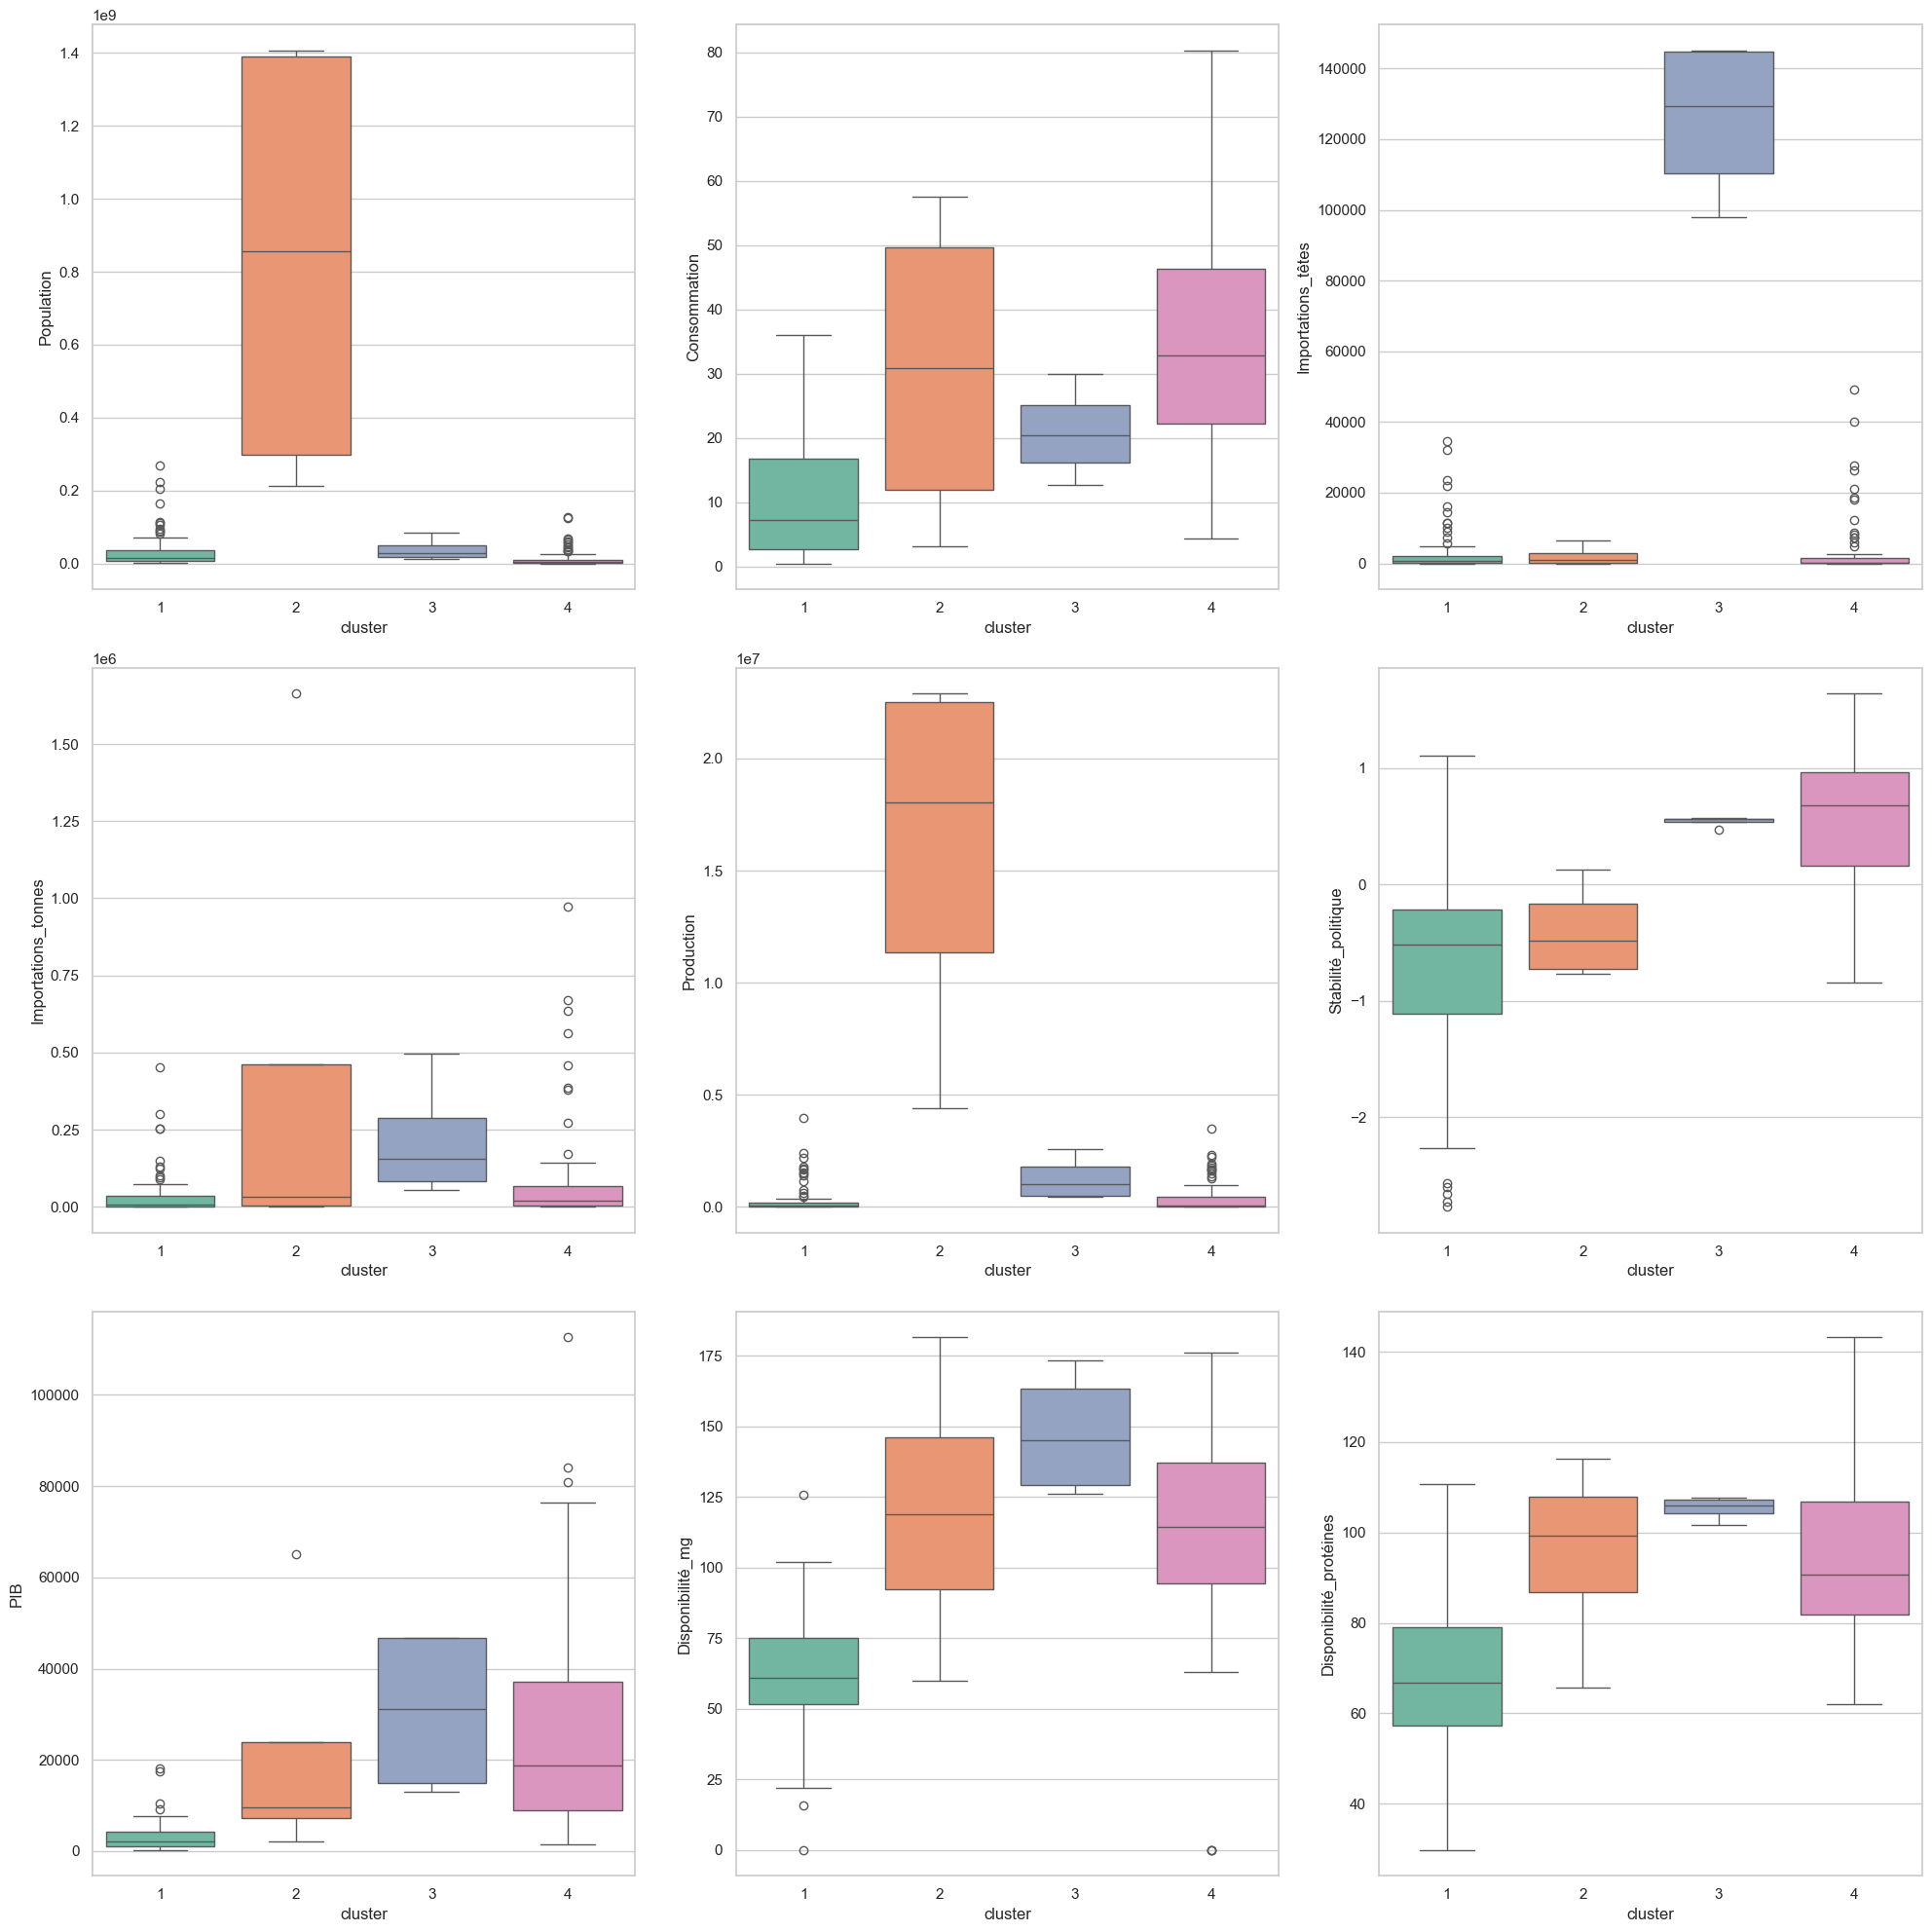

In [36]:
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

variables = column_names  # Remplacez par vos noms de colonnes appropriés

num_rows = 3
num_cols = 3

# Définir une palette de couleurs vives pour les clusters
palette = sns.color_palette("Set2", n_colors=len(df['cluster'].unique()))

for i, variable in enumerate(variables, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=df, x='cluster', y=variable, palette=palette)

plt.tight_layout()
plt.savefig("boxplot_dendogramme.png")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Cercle de corrélations</h2>
</div>

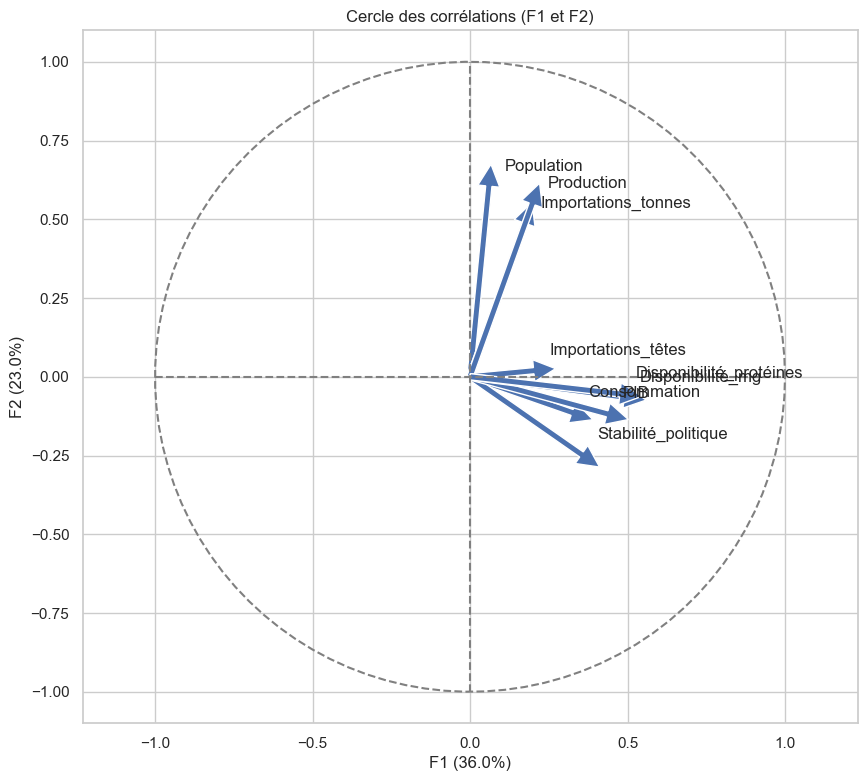

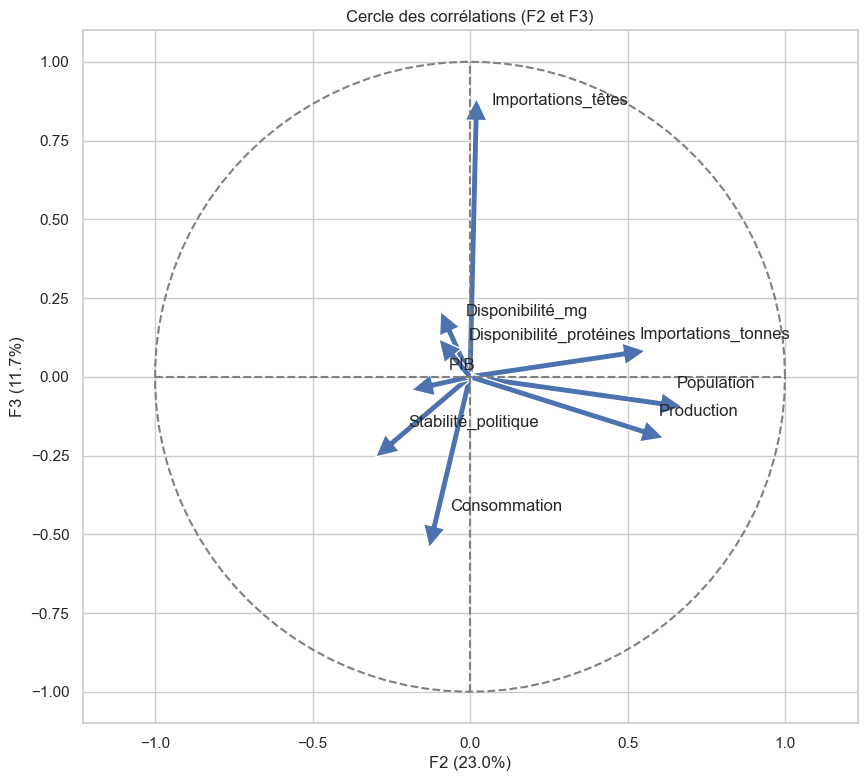

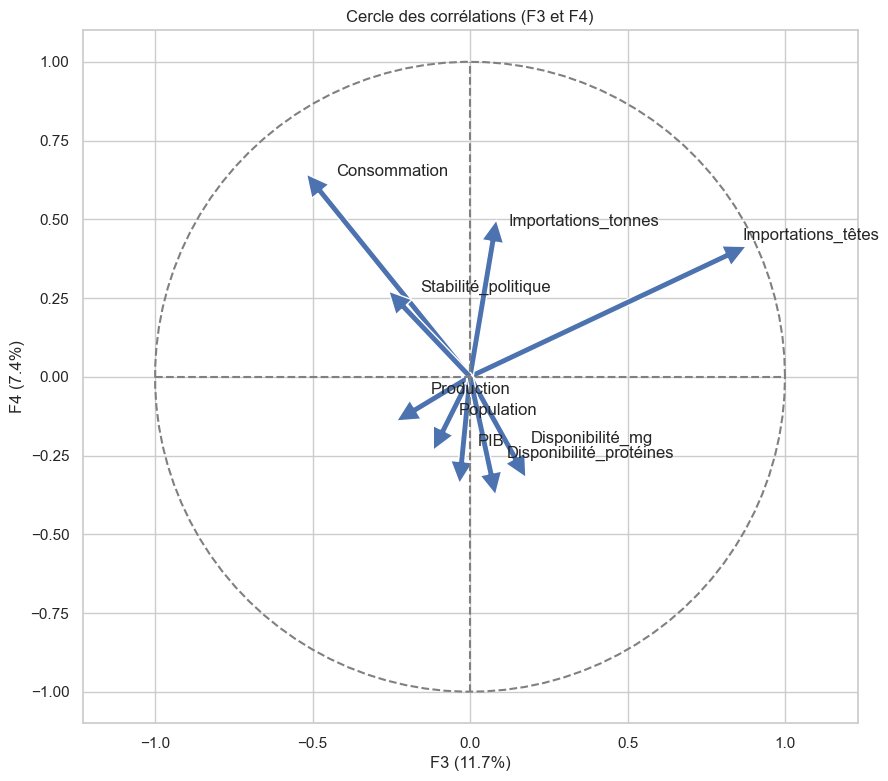

In [38]:
# Fonction pour dessiner un cercle de corrélations pour deux composantes principales
def plot_correlation_circle(components_df, pca, comp1, comp2):
    fig, ax = plt.subplots(figsize=(10, 9))
    for i in range(components_df.shape[0]):
        ax.arrow(0, 0, components_df.iloc[i, comp1], components_df.iloc[i, comp2], 
                 head_width=0.07, head_length=0.07, width=0.02)
        plt.text(components_df.iloc[i, comp1] + 0.05, components_df.iloc[i, comp2] + 0.05, 
                 components_df.index[i])

    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel(f'F{comp1+1} ({round(100*pca.explained_variance_ratio_[comp1], 1)}%)')
    plt.ylabel(f'F{comp2+1} ({round(100*pca.explained_variance_ratio_[comp2], 1)}%)')

    plt.title(f"Cercle des corrélations (F{comp1+1} et F{comp2+1})")

    # Ajouter un cercle unitaire pour l'échelle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), color='grey', ls='--')

    plt.axis('equal')
    plt.show()

# Appel de la fonction pour les différentes paires de composantes principales
plot_correlation_circle(components_df, pca, 0, 1)  # F1 et F2
plot_correlation_circle(components_df, pca, 1, 2)  # F1 et F3
plot_correlation_circle(components_df, pca, 2, 3)  # F2 et F3

F1 : Disponibilité mg / Protéiques, PIB
FF2 : Population, Production, Importation en tonnes
F3 : Importation_1000 têtes et consommation, stabilité politique
F4 : Consommation, Importation tone


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Projection des individus</h2>
</div>

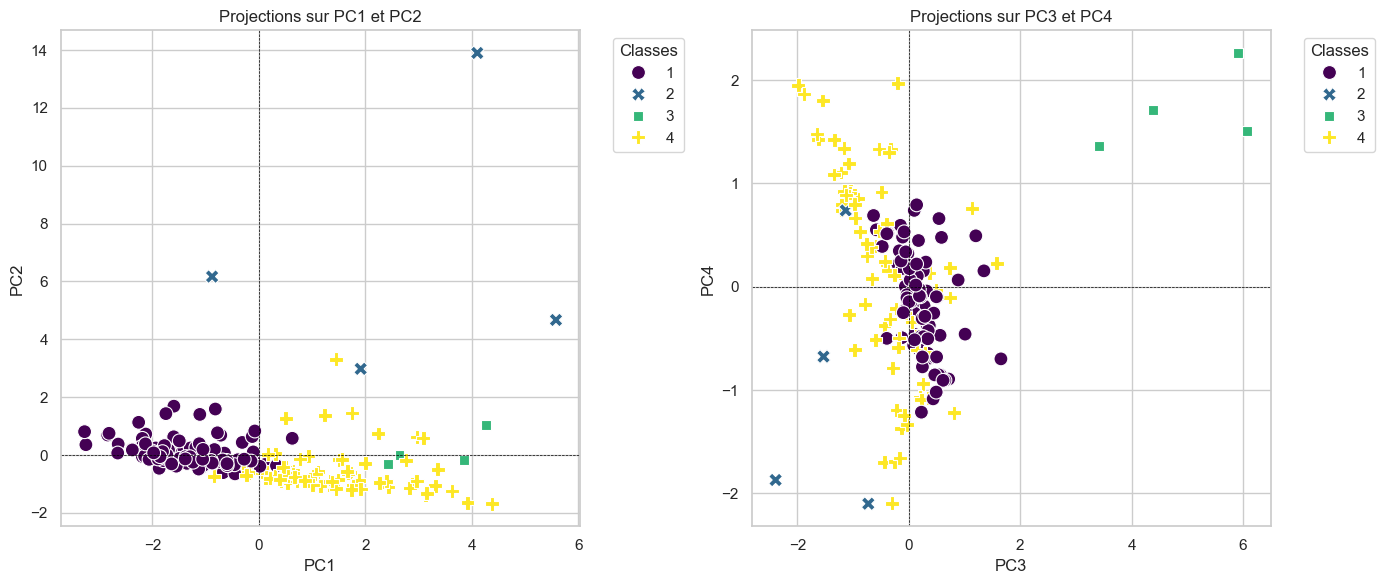

In [41]:
# Create the figure
fig = plt.figure(figsize=(14, 6))

# Projection on PC1 and PC2
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=Xk_Projected[:, 0], y=Xk_Projected[:, 1], palette='viridis', alpha=1, hue=clusters, style=clusters, s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projections sur PC1 et PC2')

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Projection on PC3 and PC4
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=Xk_Projected[:, 2], y=Xk_Projected[:, 3], palette='viridis', alpha=1, hue=clusters, style=clusters, s=100
)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Projections sur PC3 et PC4')

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Choix des pays selon les clusters et ACP</h2>
</div>

Après analyse par cluster et ACP, on peut conclure qu'il y a des pays qui se sont regroupés facielement seulon leur besoin en nourriture, dans le consommation de poulet ou pour la richesse du pays. Maintenant c'est à la compagnie de choisir selon ses propres critères de selection. Pour cette analyse je vais vous donner deux scènes différentes

Première scène : l'entreprise est associé à une organisation monidiale est souhaite aidé les pays en difficultés mais elle souhaite quand même ressortir de belle marge afin de s'agrandir. 
Il faut prendre en compte les pays où la disponibilité alimentaire est la plus basse du clusteR 1 en faisant attention à la political stability du pays

On veux les pays avec une disponibilité alimentaireen dessous de 60 g/personne/jour et une stabilité politique supp à -1 (on évite les pays en guerre ou disctatorial)

In [45]:
# Permet de reset l'index
df.reset_index(inplace=True)

In [46]:
# Faire une mrerge entre df et df_region pour retrouver les régions
df = pd.merge(df, df_region, on=['Pays'], how='inner')

In [47]:
# Filtrer les valeurs selon les préférences de l'enptreprise et le cluster 1
cluster1_choix = df.loc[(df['Disponibilité_mg'] <= 80) & (df['Region'] == 'Western Pacific') & (df['cluster'] == 1) & (df['Population'] >= 7000000) & (df['Stabilité_politique'] >= -1), :]
cluster1_choix

,Pays,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines,cluster,Region
26,Cambodia,16207746,1.790000,91,30.92,27487,-0.09,1671.385400,37.8,64.7,1,Western Pacific
84,Lao People’s Democratic Republic,7212053,5.799994,906,1050.21,37812,0.52,2598.505523,49.1,76.3,1,Western Pacific
115,Papua New Guinea,9542486,3.859999,178,24062.89,6644,-0.70,2593.775554,57.8,63.3,1,Western Pacific
118,Philippines,110380804,16.740000,72,301082.41,1508883,-0.92,3413.849044,54.6,66.7,1,Western Pacific
164,Viet Nam,95776716,13.900001,4927,254408.67,1144553,0.03,3491.091410,78.5,86.7,1,Western Pacific


Pour me focaliser uniquement dans une zone géogrpahique, j'ai opté pour l'Ouest-Pacific, qui est une bonne approche pour notre objectif d'aidé les pays en manque de nourriture. Ces pays se distingues par leur population, plus élevés que la France. Leur stabilité politique est assez bonne donc on aura peu de problème pour la négocitation.  Le vietnam est le meilleur choix, ils ont une consommation de poulet assez élévés avec une production / importation  faible.

Seconde scène : Les pays riches avec une population faible mais importe une grande quantité de poulet avec une fiable production. Le cluster 3.

In [50]:
# Filtrer les valeurs selon les préférences de l'enptreprise et le cluster 3
cluster3_choix = df.loc[(df['cluster'] == 3), :]
cluster3_choix

,Pays,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines,cluster,Region
15,Belgium,11488980,12.750002,144515,219622.99,447750,0.47,46641.721402,173.4,101.7,3,Europe
57,Germany,83092962,17.380000,145190,497106.39,1543866,0.57,46805.138433,160.2,105.0,3,Europe
119,Poland,37965475,29.970001,98059,55257.26,2567684,0.56,15700.013580,130.3,107.7,3,Europe
124,Romania,19371648,23.459997,114260,90501.64,507106,0.56,12957.999114,126.1,107.0,3,Europe


Ce choix de pays est très interessant, ils regroupent uniquement des pays européens. Vous pouvez voir que l'importation_tonnes est conséquentes donc il serait facile d'integrer le marché. On a uniquement 4 pays, je vais ajouté un pays qui n'est pas dans le cluster 3 mais qui s'en rapprochent énormément ( même zone géograpique, dépendance de leur consommation par de l'importation de poulet). Je parle bien de l'espagne qui est un candidat parfait du fait de sa proximité direct.

In [97]:
Spain = df.loc[(df['Pays'] == 'Spain'), :]
Spain

,Pays,Population,Consommation,Importations_têtes,Importations_tonnes,Production,Stabilité_politique,PIB,Disponibilité_mg,Disponibilité_protéines,cluster,Region
139,Spain,47134837,33.18,49326,95461.05,1630610,0.31,29581.518551,153.6,110.3,4,Europe


Maintenant on a deux groupes de pays qui pourrait nous interesser selon le besoin de l'entreprise.